In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create two tensors and move them to the GPU
a = torch.randn(10000, 10000, device=device)
b = torch.randn(10000, 10000, device=device)

# Perform a matrix multiplication on the GPU
result = torch.matmul(a, b)

# Move result back to CPU if needed
result_cpu=result.cpu()

Using device: cuda


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from PIL import UnidentifiedImageError

# import data handling tools
#import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



print('Modules loaded')
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from PIL import UnidentifiedImageError

# import data handling tools




Modules loaded


In [ ]:
# loading the dataset with error handling for image loading
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []
    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            try:
                # Attempt to open the image file
                img = Image.open(fpath)
                # If successful, append the file path and label
                filepaths.append(fpath)
                labels.append(fold)
            except (UnidentifiedImageError, OSError) as e:
                # If unable to open the image file, skip it and print the error
                print(f"Error loading image: {fpath} - {e}")
                continue

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df


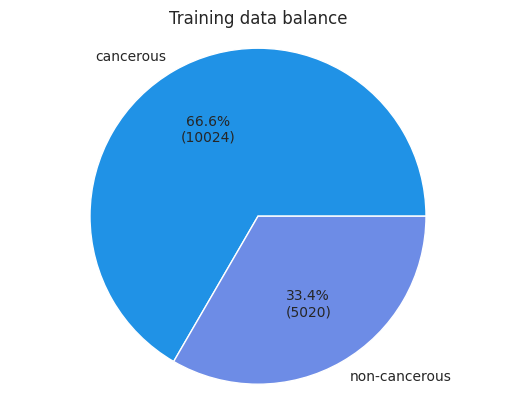

Found 12035 validated image filenames belonging to 2 classes.
Found 1504 validated image filenames belonging to 2 classes.
Found 1505 validated image filenames belonging to 2 classes.


In [ ]:
# change label names to their original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'cancerous', 'lung_n': 'non-cancerous', 'lung_scc': 'cancerous'}
    df[column_name] = df[column_name].replace(index)

# loading the data
data_dir = '/content/drive/MyDrive/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


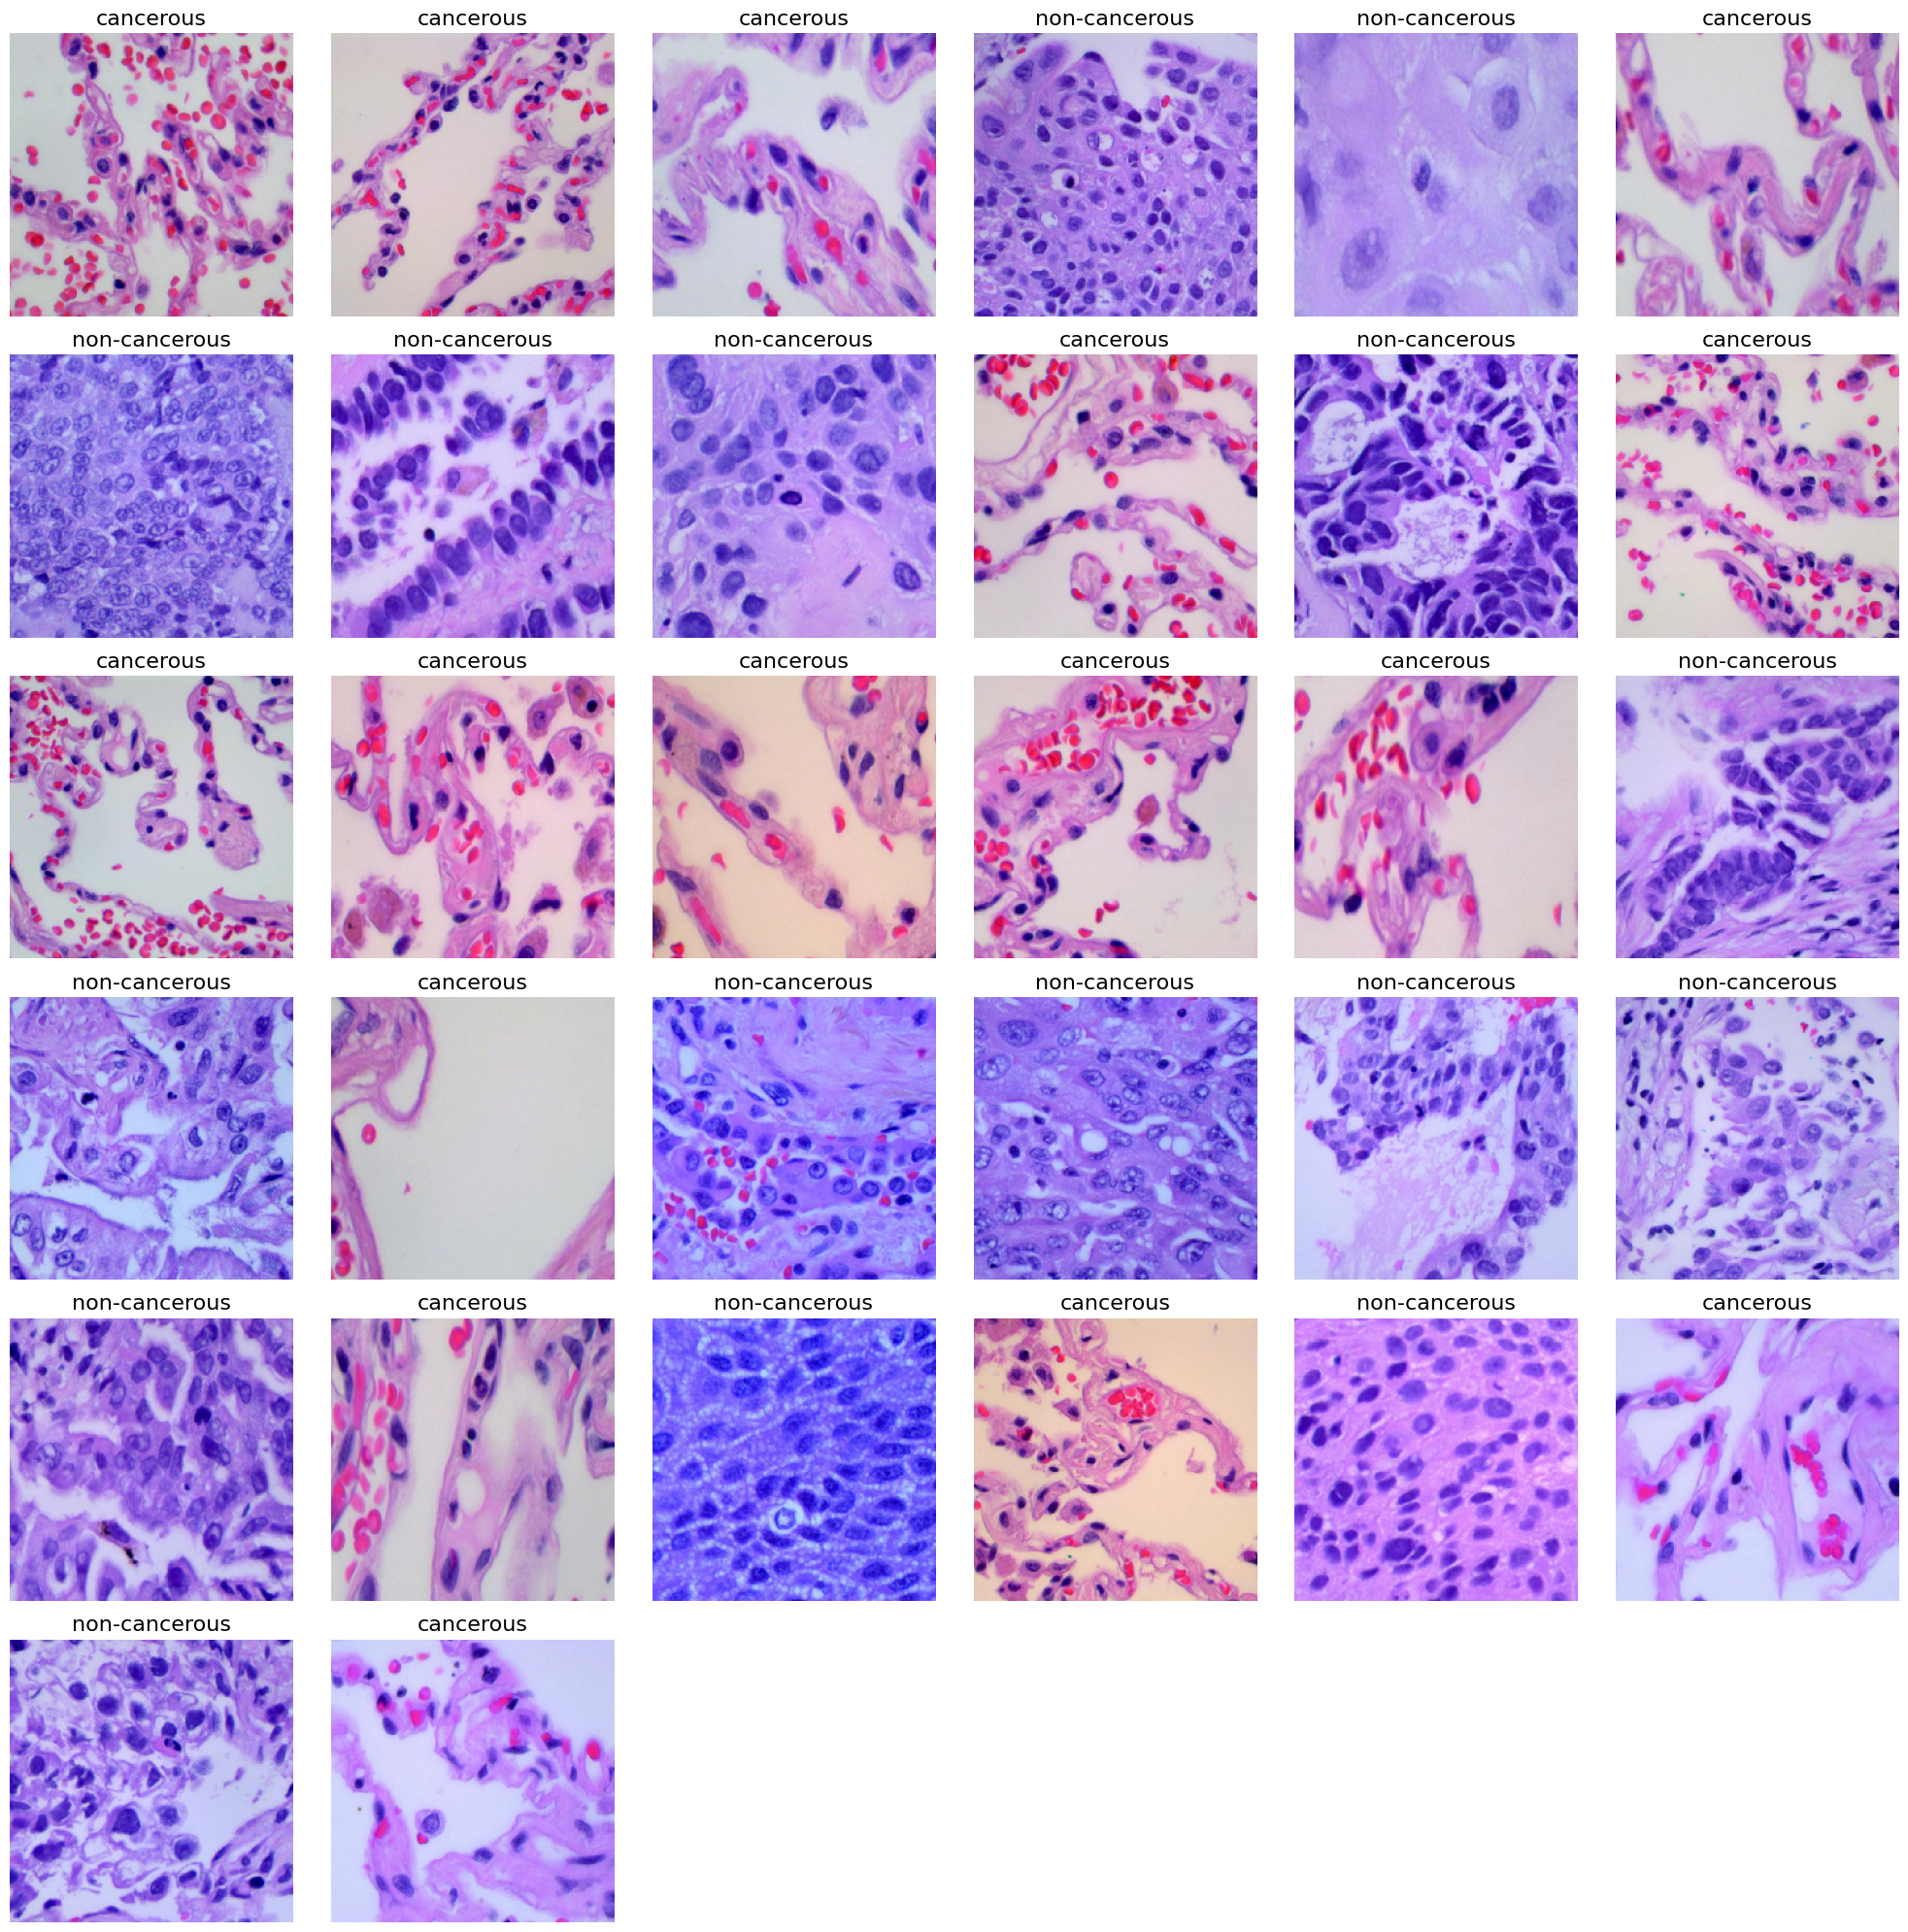

In [ ]:
# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = int(labels[i])  # get image index
    class_name = 'cancerous' if index == 1 else 'non-cancerous'  # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.round(preds).flatten().astype(int)

    return y_pred

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [ ]:
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = 2  # 2 classes for binary classification (cancerous vs. non-cancerous)

# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv block
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer for binary classification
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

# train the model
epochs = 2  # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)


cnn_model.save('2_epoch_model_new.keras')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_25 (Sequential)      │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_26 (Sequential)      │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_27 (Sequential)      │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_28 (Sequential)      │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,457 (10.66 MB)

 Trainable params: 2,794,017 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

Epoch 1/2
377/377 ━━━━━━━━━━━━━━━━━━━━ 105s 244ms/step - accuracy: 0.9272 - loss: 0.1944 - val_accuracy: 0.6822 - val_loss: 8.0899
Epoch 2/2
377/377 ━━━━━━━━━━━━━━━━━━━━ 88s 234ms/step - accuracy: 0.9893 - loss: 0.0472 - val_accuracy: 0.9694 - val_loss: 0.0861


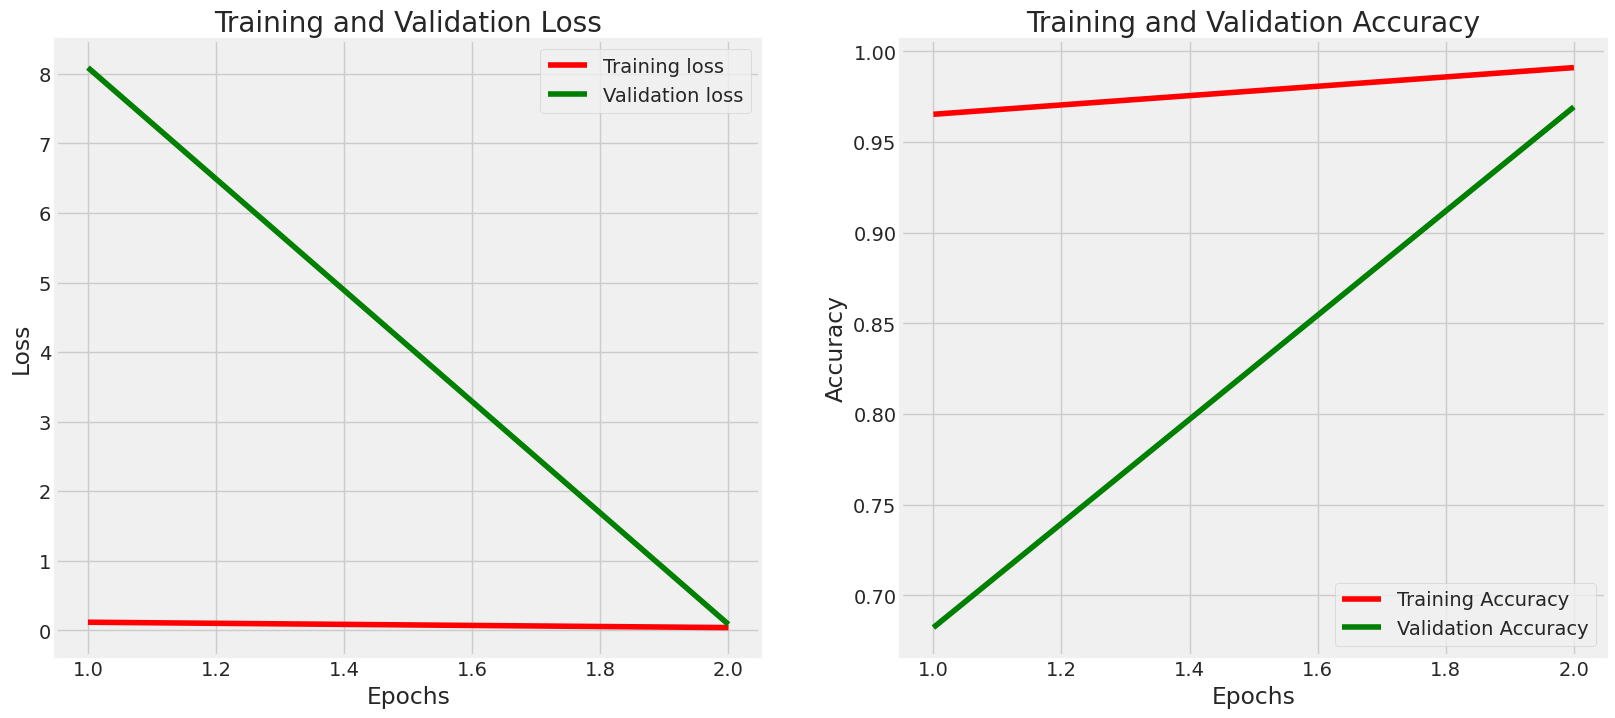

377/377 ━━━━━━━━━━━━━━━━━━━━ 75s 198ms/step - accuracy: 0.9667 - loss: 0.0939
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.9727 - loss: 0.0787
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.9684 - loss: 0.0973
Train Loss:  0.08829143643379211
Train Accuracy:  0.9689239859580994
--------------------
Validation Loss:  0.0860825702548027
Validation Accuracy:  0.9694148898124695
--------------------
Test Loss:  0.09131334722042084
Test Accuracy:  0.9661129713058472
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step


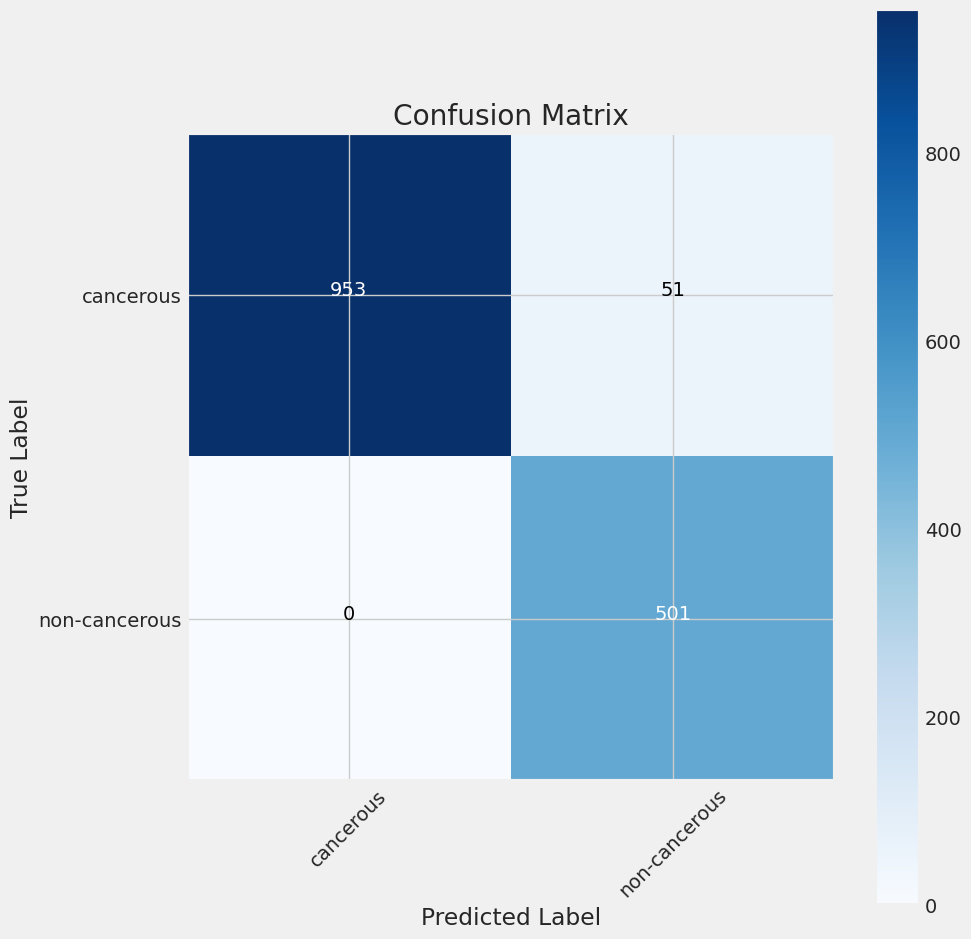

               precision    recall  f1-score   support

    cancerous       1.00      0.95      0.97      1004
non-cancerous       0.91      1.00      0.95       501

     accuracy                           0.97      1505
    macro avg       0.95      0.97      0.96      1505
 weighted avg       0.97      0.97      0.97      1505



In [ ]:
model_performance(history, epochs)
model_evaluation(cnn_model)
y_pred = get_pred(cnn_model, test_gen)
plot_confusion_matrix(test_gen, y_pred)
from sklearn.metrics import classification_report

print(classification_report(test_gen.classes, y_pred, target_names=classes))

NameError: name 'y_pred' is not defined